# Lena Hamilton
# Project Part 3

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://www.kaggle.com/code/lena13/fork-of-notebook70f92d4f56/edit)


## 1.  Writeup
I will be using a dataset found on Kaggle through the NLP and most downloaded filters.  At four years since its last update, this is a somewhat old dataset. I am optimistic that the high number of learning based notebooks that use this dataset is an indicator that it will be a good choice for this project.

* https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction/data

The data is a collection of job postings with a binary flag to denote whether it is a real or fake job post. The dataset does not indicate where the data came from, but it does show that the authors of it are from the University of the Aegean, and that is public domain under the CC0 licence.

This is a good NLP problem because it is trying to determine if there are any clues in the written descriptions that would indicate the falsity of the job posting.



## 2. Exploratory Data Analysis


In [1]:
# import all of the python modules/packages you'll need here
import pandas as pd
# ...
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.metrics import classification_report,confusion_matrix,r2_score

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
data1 = pd.read_csv("../input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv")
data1.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
data1.describe().T

,count,mean,std,min,25%,50%,75%,max
job_id,17880.0,8940.500000,5161.655742,1.0,4470.75,8940.5,13410.25,17880.0
telecommuting,17880.0,0.042897,0.202631,0.0,0.00,0.0,0.00,1.0
has_company_logo,17880.0,0.795302,0.403492,0.0,1.00,1.0,1.00,1.0
has_questions,17880.0,0.491723,0.499945,0.0,0.00,0.0,1.00,1.0
fraudulent,17880.0,0.048434,0.214688,0.0,0.00,0.0,0.00,1.0


In [4]:
data1.duplicated().sum()

0

In [5]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [6]:
data1["fraudulent"].value_counts()

fraudulent
0    17014
1      866
Name: count, dtype: int64

This very first look at the data show that it is highly imbalenced twards the 'real' category.

In [7]:
data1.isnull().sum()/len(data1)*100

job_id                  0.000000
title                   0.000000
location                1.935123
department             64.580537
salary_range           83.959732
company_profile        18.501119
description             0.005593
requirements           15.078300
benefits               40.335570
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type        19.412752
required_experience    39.429530
required_education     45.329978
industry               27.421700
function               36.101790
fraudulent              0.000000
dtype: float64

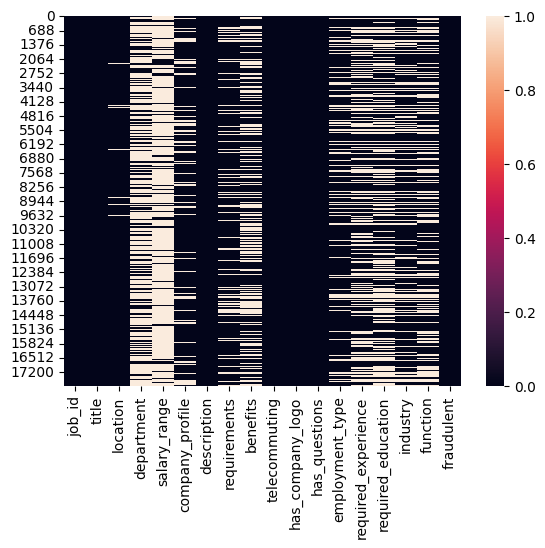

In [8]:
sns.heatmap(data1.isnull());

Department, salary_range, company_profile, requirements, benefits, employment_type, required_experience, required_education, industry, function columns have very high percentage of missing value

This is a measure list of null values in the dataset

In [9]:
text_data1 = data1[["title", "company_profile", "description", "requirements", "benefits","fraudulent"]]
text_data1 = text_data1.fillna(' ')

text_data1.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


The data that have text in it

In [10]:
cat_data1 = data1[["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education", "industry", "function","fraudulent"]]
cat_data1 = cat_data1.fillna("None")

cat_data1.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,0,Other,Internship,None,None,Marketing,0
1,0,1,0,Full-time,Not Applicable,None,Marketing and Advertising,Customer Service,0
2,0,1,0,None,None,None,None,None,0
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


columns with either binary or category data

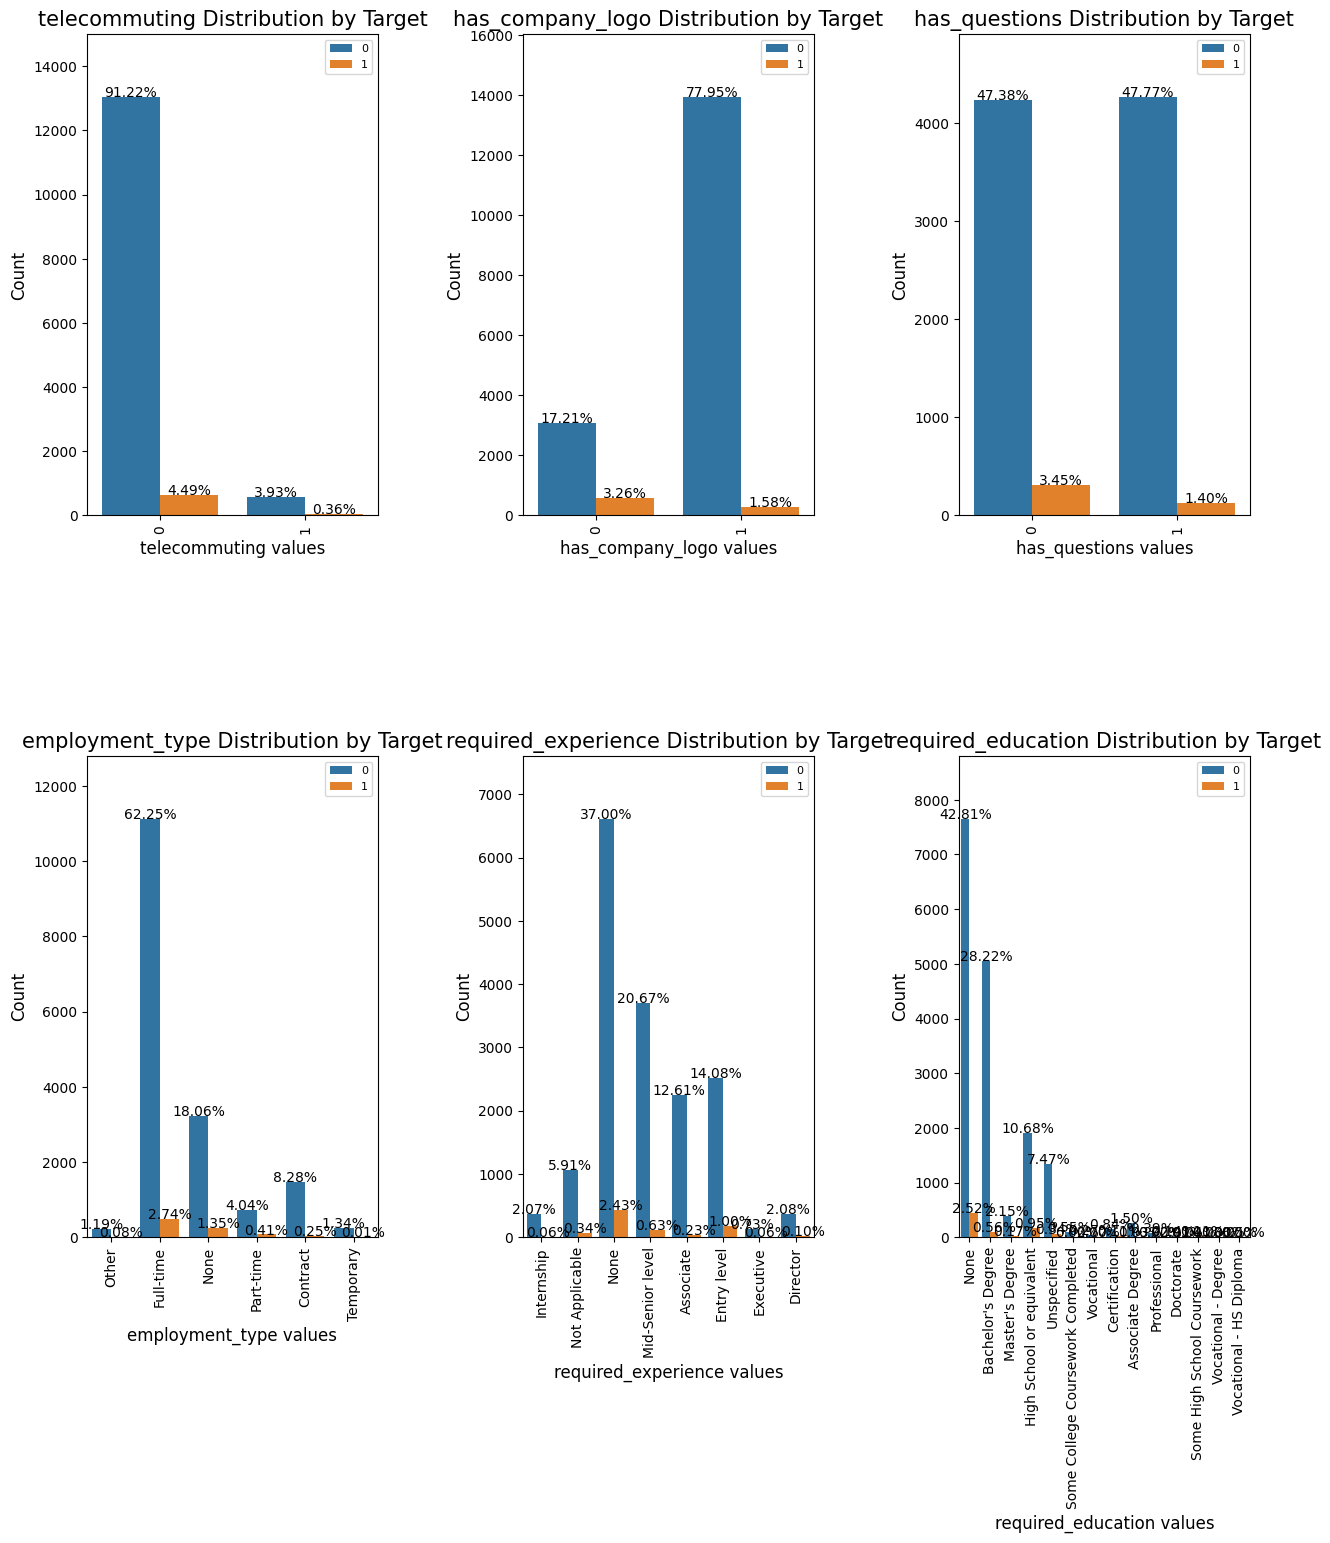

In [11]:
cat_columns = ["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education",]
# visualizating catagorical variable by target
import matplotlib.gridspec as gridspec # to do the grid of plots
grid = gridspec.GridSpec(3, 3, wspace=0.5, hspace=0.5) # The grid of chart
plt.figure(figsize=(15,25)) # size of figure


for n, col in enumerate(cat_data1[cat_columns]): 
    ax = plt.subplot(grid[n]) # feeding the figure of grid
    sns.countplot(x=col, data=cat_data1, hue='fraudulent') 
    ax.set_ylabel('Count', fontsize=12) # y axis label
    ax.set_title(f'{col} Distribution by Target', fontsize=15) # title label
    ax.set_xlabel(f'{col} values', fontsize=12) # x axis label
    xlabels = ax.get_xticklabels() 
    ylabels = ax.get_yticklabels() 
    ax.set_xticklabels(xlabels,  fontsize=10)
    ax.set_yticklabels(ylabels,  fontsize=10)
    plt.legend(fontsize=8)
    plt.xticks(rotation=90) 
    total = len(cat_data1)
    sizes=[] # Get highest values in y
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=10) 
    ax.set_ylim(0, max(sizes) * 1.15) #set y limit based on highest heights


plt.show()

Blue is the real postings, and orange is the fake

In [12]:
text_data1=data1.select_dtypes(include="object")
text_data1.drop(["location","salary_range"],axis=1,inplace=True)

text_col=text_data1.columns

In [13]:
text_col

Index(['title', 'department', 'company_profile', 'description', 'requirements',
       'benefits', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function'],
      dtype='object')

In [14]:
data1[text_col]=data1[text_col].replace(np.nan,"")
data1["text"]=""

for col in text_data1.columns:
    data1["text"]=data1["text"]+" "+data1[col]
    
data1["text"].iloc[0]

" Marketing Intern Marketing We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Food52, a fast-growing, James Beard Award-winning online food community and crowd-sou

In [15]:
def fea(text):
    if text=="":
        return 0
    else:
        return 1
    
for col in text_col:
    data1[col]=data1[col].apply(fea)
    
data1.isnull().sum()/len(data1)*100

job_id                  0.000000
title                   0.000000
location                1.935123
department              0.000000
salary_range           83.959732
company_profile         0.000000
description             0.000000
requirements            0.000000
benefits                0.000000
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type         0.000000
required_experience     0.000000
required_education      0.000000
industry                0.000000
function                0.000000
fraudulent              0.000000
text                    0.000000
dtype: float64

In [16]:
data1.drop(["salary_range","job_id"],axis=1,inplace=True)

In [17]:
data1.dropna(axis=0,inplace=True)

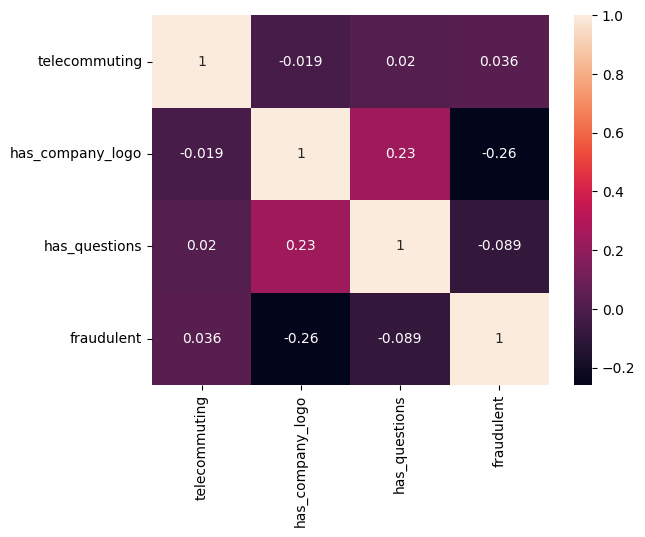

In [18]:
sns.heatmap(data1[["telecommuting","has_company_logo","has_questions","fraudulent"]].corr(),annot=True);

In [19]:
features=['title','department', 'company_profile', 'requirements','description',
          'benefits', 'employment_type', 'required_experience',
          'required_education', 'industry', 'function','fraudulent']

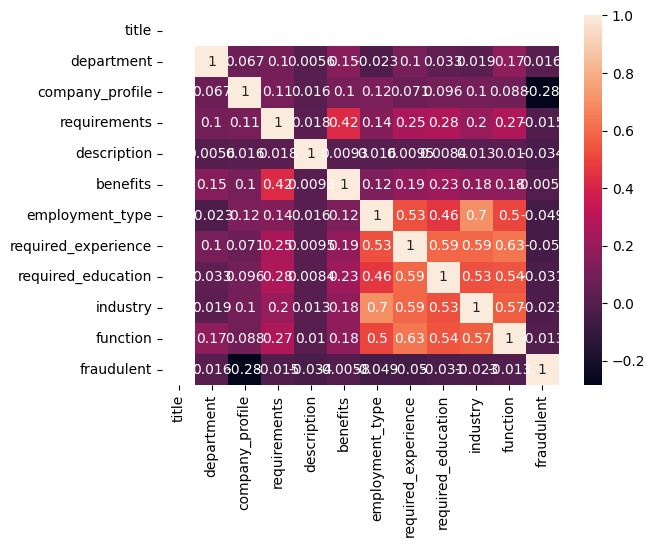

In [20]:
sns.heatmap(data1[features].corr(),annot=True);

In [21]:
drop_col=['title','department', 'description', 'requirements',
          'benefits', 'employment_type', 'required_experience',
          'required_education', 'industry', 'function']

data1.drop(drop_col,axis=1,inplace=True)

# 3. Baseline Model

In [22]:
stop=set(stopwords.words("english"))

In [23]:
data1["text"].iloc[0]

" Marketing Intern Marketing We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Food52, a fast-growing, James Beard Award-winning online food community and crowd-sou

In [24]:
def clean(text):
    
    text=text.lower()
    obj=re.compile(r"<.*?>")                     #removing html tags
    text=obj.sub(r" ",text)
    obj=re.compile(r"https://\S+|http://\S+")    #removing url
    text=obj.sub(r" ",text)
    obj=re.compile(r"[^\w\s]")                   #removing punctuations
    text=obj.sub(r" ",text)
    obj=re.compile(r"\d{1,}")                    #removing digits
    text=obj.sub(r" ",text)
    obj=re.compile(r"_+")                        #removing underscore
    text=obj.sub(r" ",text)
    obj=re.compile(r"\s\w\s")                    #removing single character
    text=obj.sub(r" ",text)
    obj=re.compile(r"\s{2,}")                    #removing multiple spaces
    text=obj.sub(r" ",text)
   
    
    stemmer = SnowballStemmer("english")
    text=[stemmer.stem(word) for word in text.split() if word not in stop]
    
    return " ".join(text)

In [25]:
data1["text"]=data1["text"].apply(clean)

In [26]:
data1["text"].iloc[0]

'market intern market food creat groundbreak award win cook site support connect celebr home cook give everyth need one place top editori busi engin team focus use technolog find new better way connect peopl around specif food interest offer superb high curat inform food cook attract talent home cook contributor countri also publish well known profession like mario batali gwyneth paltrow danni meyer partnership whole food market random hous food name best food websit jame beard foundat iacp featur new york time npr pando daili techcrunch today show locat chelsea new york citi food fast grow jame beard award win onlin food communiti crowd sourc curat recip hub current interview full part time unpaid intern work small team editor execut develop new york citi headquart reproduc repackag exist food content number partner site huffington post yahoo buzzfe various content manag systemsresearch blog websit provis food affili programassist day day affili program support screen affili assist af

In [27]:
X=data1.drop(['fraudulent'],axis=1)
Y=data1['fraudulent']


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=101)

split the data into feature & target, and training & test sets

In [28]:
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(X_train).toarray()


print(f"X_train.shape = {X_train.shape}")
type(X_train)

X_train.shape = (6, 6)


numpy.ndarray

I Will be using the Gaussian for the base model for this project, and xgb classifier for hyperparameter.

In [29]:
vectorizer=TfidfVectorizer(strip_accents='unicode',
                           analyzer='word',
                           ngram_range=(1, 2),
                           max_features=15000,
                           smooth_idf=True,
                           sublinear_tf=True)

vectorizer.fit(data1["text"])
X = vectorizer.transform(data1["text"])

In [30]:
X.shape

(17534, 15000)

In [31]:
pca = PCA(n_components=0.95)

X = pca.fit_transform(X.toarray())

In [32]:
X.shape

(17534, 4507)

In [33]:
x=range(1,X.shape[1]+1)
cumsum = np.cumsum(pca.explained_variance_ratio_)

#sns.scatterplot(x,y=cumsum);

In [34]:
y=data1["fraudulent"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [35]:
model=GaussianNB()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

In [36]:
print(f"Accuracy score: {accuracy_score(y_test,y_pred)}")

Accuracy score: 0.5865412033076703


In [37]:
print(f"classification_report:\n {classification_report(y_test,y_pred)}")

classification_report:
               precision    recall  f1-score   support

           0       0.98      0.58      0.73      3341
           1       0.08      0.78      0.15       166

    accuracy                           0.59      3507
   macro avg       0.53      0.68      0.44      3507
weighted avg       0.94      0.59      0.70      3507



In [38]:
print(f"confusion_matrix:\n {confusion_matrix(y_test,y_pred)}")

confusion_matrix:
 [[1927 1414]
 [  36  130]]


In [39]:
cf_matrix=confusion_matrix(y_test,y_pred)

<Axes: >

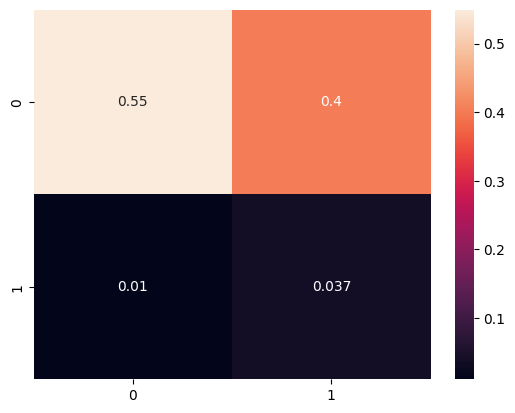

In [40]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot = True)

In [41]:
model=XGBClassifier( learning_rate = 0.1,
                     n_estimators = 1000,
                     max_depth = 5,
                     min_child_weight = 1,
                     gamma = 0,
                     subsample = 0.8,
                     colsample_bytree = 0.8,
                     objective = 'binary:logistic',
                     nthread = 4,
                     eval_metric = "logloss",
                     use_label_encoder = False)

In [42]:
xgb_param = model.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, label = y_train)

early_stopping_rounds = 50

cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round = model.get_params()['n_estimators'], 
                  nfold = 3, metrics = 'auc', early_stopping_rounds = early_stopping_rounds)

model.set_params(n_estimators = cvresult.shape[0])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=221,
              n_jobs=None, nthread=4, num_parallel_tree=None, ...)

In [43]:
cvresult.shape[0]

221

In [44]:
esti = cvresult.shape[0]

In [45]:
#param_test = {"max_depth":range(3,10,2),
#               "min_child_weight":range(1,6,2)}

#gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1,
#                                                  n_estimators=esti,
#                                                  gamma=0,
#                                                  subsample=0.8,
#                                                  colsample_bytree=0.8,
#                                                  objective= 'binary:logistic',
#                                                  eval_metric="logloss",
#                                                  nthread=4,
#                                                  seed=27,
 #                                                 use_label_encoder=False),
#                        param_grid = param_test,
#                        n_jobs=2, cv=3)

#gsearch.fit(X_train,y_train)

In [46]:
#gsearch.best_params_

In [47]:
#best_param1=gsearch.best_params_

In [48]:
#gsearch.best_score_